In [1]:
import pandas as pd
import numpy as np 
from pathlib import Path
import json

import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler


from src.concrete.ml.sklearn import LinearRegression

import warnings
warnings.filterwarnings('ignore')

/Users/marc/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def format_large_numbers(x, pos):
    if np.abs(x) >= 1e9:
        return f'{x * 1e-9:.1f}B'  # Format as Billion
    elif np.abs(x) >= 1e6:
        return f'{x * 1e-6:.1f}M'  # Format as Million
    elif np.abs(x) >= 1e3:
        return f'{x * 1e-3:.1f}K'  # Format as Thousand
    else:
        return f'{x:.0f}'  # Less than 1,000

In [3]:
DATA_PATH = Path('demo-data/medical.csv')
CLIENT_1_DIR = DATA_PATH / "client_1"
CLIENT_2_DIR = DATA_PATH / "client_2"

df = pd.read_csv(DATA_PATH)

In [4]:
label_encoder_sex = LabelEncoder()
label_encoder_smoker = LabelEncoder()
label_encoder_region = LabelEncoder()
df['sex'] = label_encoder_sex.fit_transform(df['sex'])
df['smoker'] = label_encoder_smoker.fit_transform(df['smoker'])
df['region'] = label_encoder_region.fit_transform(df['region'])
df


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
2767,47,0,45.320,1,0,2,8569.86180
2768,21,0,34.600,0,0,3,2020.17700
2769,19,1,26.030,1,1,1,16450.89470
2770,23,1,18.715,0,0,1,21595.38229


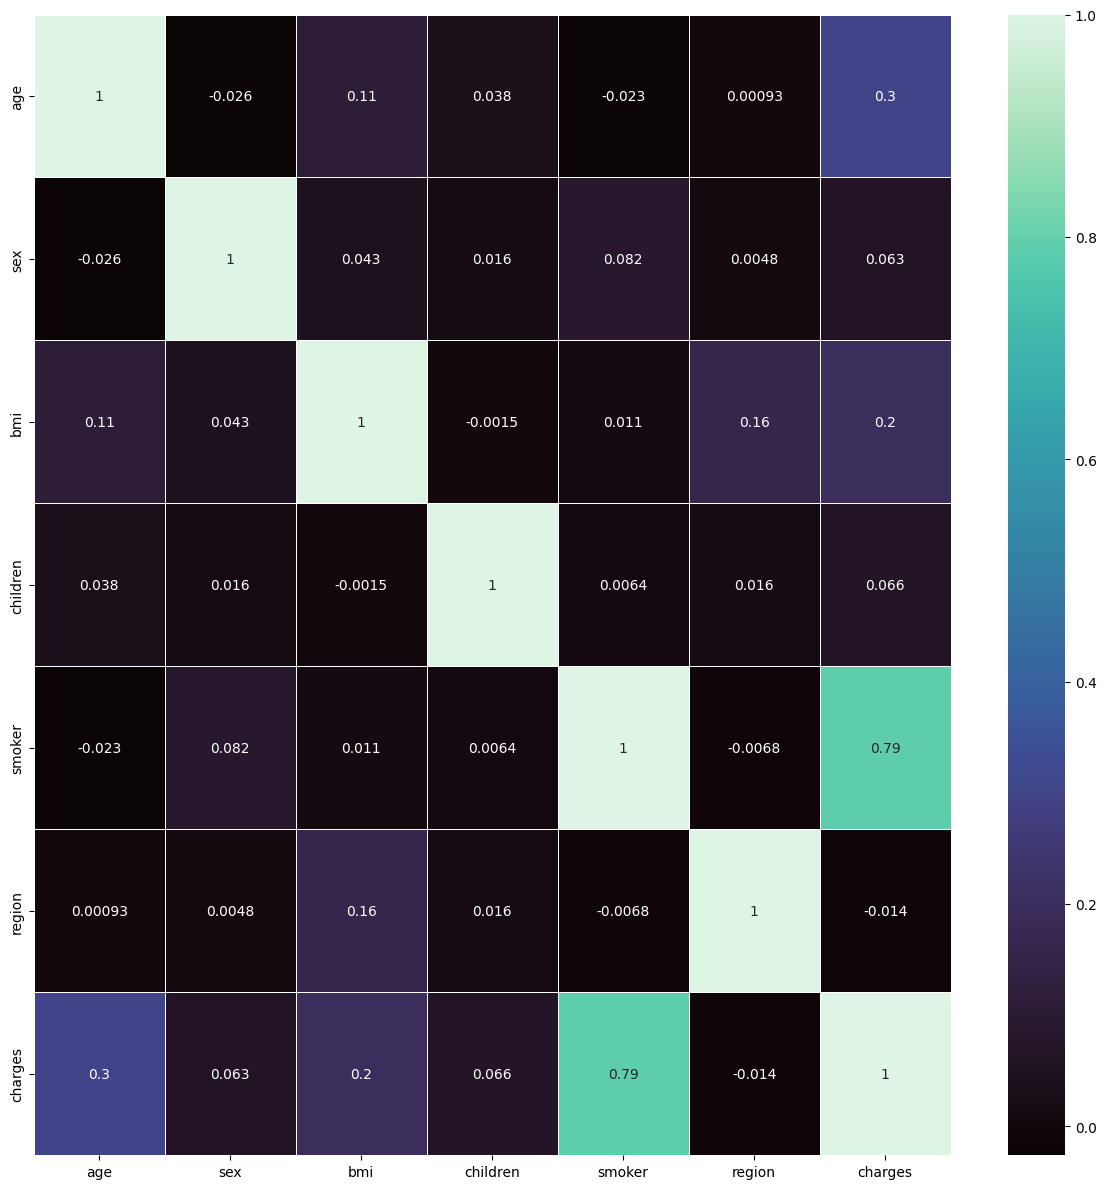

In [5]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax=ax, cmap="mako")

fig.tight_layout()

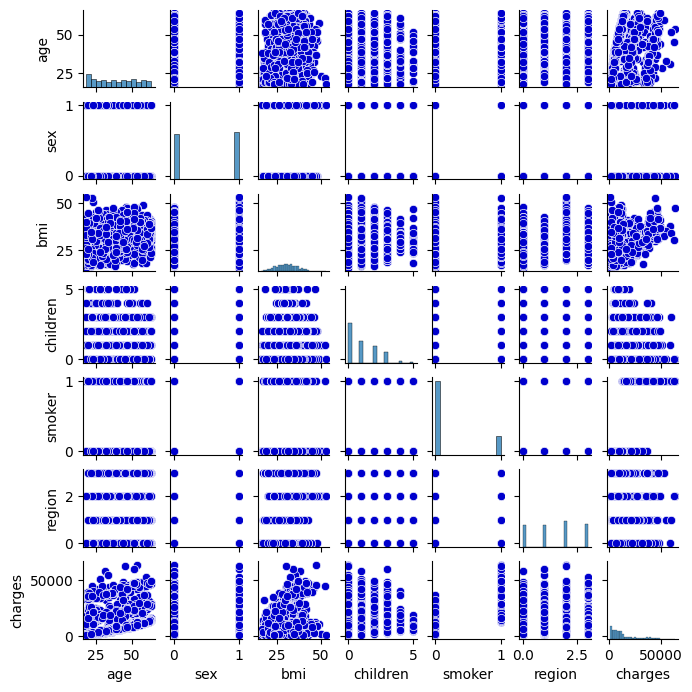

In [6]:
sns.pairplot(df, 
             height=1, aspect=1, 
             corner=False,
             plot_kws={'color': 'mediumblue'})
plt.show()

In [7]:
df['age'] = df['age'].astype(float)
df['sex'] = df['sex'].astype(float)
df['smoker'] = df['smoker'].astype(float)
df['children'] = df['children'].astype(float)


In [12]:
X = df['smoker'].values.reshape(-1,1)
y = df['charges'].values

linear_model = LinearRegression(n_bits=8)
linear_model.fit(X, y)

linear_model.compile(X)

dumped_model_path = Path("demo-data/linear_reg.json")

# Any kind of file-like object can be used 
with dumped_model_path.open("w") as f:
    # Dump the model in a file
    linear_model.dump(f)

with open("demo-data/linear_reg.json", 'r') as j:
     contents = json.loads(j.read())

model = contents['type_name']
serialized_value = np.array(contents['serialized_value']['_q_weights']['serialized_value'])

# Predict on the test set
y_pred_linear, proof = linear_model.predict(X, model, 
                                            serialized_value, fhe="execute")

# Calculate R^2 for the linear model
r2_linear = r2_score(y, y_pred_linear)
print(f'Linear Model R^2: {r2_linear:.2f}')


Linear Model R^2: 0.62


In [38]:
list(zip(X, linear_model.coef_)), linear_model.intercept_

([(array([1.]), 23805.26535247587)], 8417.87441114055)

In [13]:
X = df[['age', 'bmi', 'smoker']]
y = df['charges']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
linear_model = LinearRegression(n_bits=8)
linear_model.fit(X_train, y_train)

linear_model.compile(X_train)

dumped_model_path = Path("demo-data/linear_reg_multi.json")

# Any kind of file-like object can be used 
with dumped_model_path.open("w") as f:
    # Dump the model in a file
    linear_model.dump(f)

with open("demo-data/linear_reg_multi.json", 'r') as j:
     contents = json.loads(j.read())

model = contents['type_name']
serialized_value = np.array(contents['serialized_value']['_q_weights']['serialized_value'])

# Predict on the test set
y_pred_linear, proof = linear_model.predict(X_test, model, 
                                            serialized_value,  fhe="execute")

# Calculate R^2 for the linear model
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Model R^2: {r2_linear:.2f}')


Linear Model R^2: 0.73


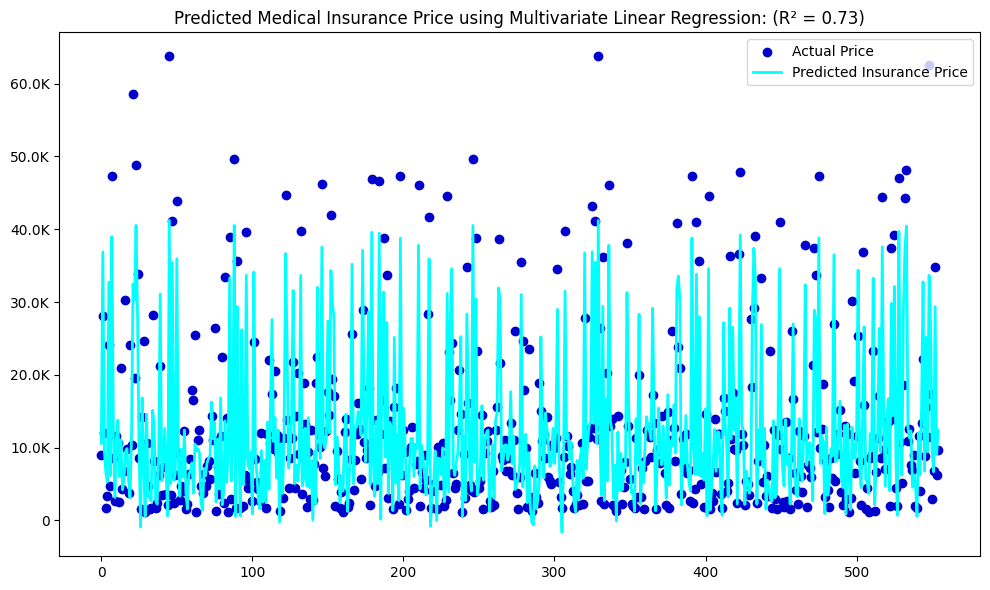

In [16]:
# Scatter plots and regression lines for the full set of variables
# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.scatter(range(len(y_test)), y_test, color='mediumblue', label='Actual Price')
ax1.plot(range(len(y_pred_linear)), y_pred_linear, color='cyan', label='Predicted Insurance Price', linewidth=2)
ax1.set_title(f'Predicted Medical Insurance Price using Multivariate Linear Regression: (R² = {r2_linear:.2f})')
ax1.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
ax1.legend()

fig.tight_layout()

plt.show()

In [17]:
linear_model = LinearRegression(n_bits=8)
scaler = StandardScaler()
X = scaler.fit_transform(X)


linear_model.fit(X, y)

linear_model.compile(X)

dumped_model_path = Path("demo-data/linear_reg_multi.json")

# Any kind of file-like object can be used 
with dumped_model_path.open("w") as f:
    # Dump the model in a file
    linear_model.dump(f)

with open("demo-data/linear_reg_multi.json", 'r') as j:
     contents = json.loads(j.read())

model = contents['type_name']
serialized_value = np.array(contents['serialized_value']['_q_weights']['serialized_value'])

# Predict on the test set
y_pred_linear, proof = linear_model.predict(X, model, 
                                            serialized_value, fhe="execute")

# Calculate R^2 for the linear model
r2_linear = r2_score(y, y_pred_linear)
print(f'Linear Model R^2: {r2_linear:.2f}')


Linear Model R^2: 0.75


In [71]:
list(zip(X, linear_model.coef_)), linear_model.intercept_

([('age', 3637.2998730080435),
  ('bmi', 1906.0320852542175),
  ('smoker', 9646.184951332989)],
 13261.369959046897)

In [73]:
scaler.mean_, scaler.var_

(array([39.30897609, 30.71545332,  0.20929184]),
 array([1.94024967e+02, 3.72320824e+01, 1.65488763e-01]))

$y = 13261.369959046897 + 3637.2998730080435 * \frac{(age-39.30897609)}{1.94024967e+02} + 1906.0320852542175 * \frac{(bmi-30.71545332)}{3.72320824e+01} + 9646.184951332989 * \frac{(smoker-0.20929184)}{1.65488763e-01}$

In [83]:
age = float(input("What is your age?:"))
bmi = float(input("What is your bmi?:"))
smoker = input("Do you smoke?:")
smoker = [str(smoker).lower()]
smoker = label_encoder_smoker.transform(smoker)
array = [[age, bmi, smoker[0]]]
array


[[23.0, 24.7, 0]]

In [84]:
array_scaled = scaler.transform(array)
y_pred_linear, proof = linear_model.predict(array_scaled, model, serialized_value, 
                                    "1234", fhe="execute")


In [89]:
np.savetxt("demo-data/x_test.csv", array_scaled, delimiter=",")

In [88]:
np.savetxt("demo-data/X.csv", X, delimiter=",")